In [ ]:
using CSV
using DataFrames
using Plots
using StatsPlots
using GLM
using Statistics
using Distributions
using Random
using MLBase
using Makie
using Flux
using ProgressMeter

# Obtencion de los datos

In [ ]:
# Obtener los datos
datos = DataFrame(CSV.read("Churn_Modelling.csv", DataFrame))

@show(describe(datos))
@show(names(datos))
println()

describe(datos) = 14×7 DataFrame
 Row │ variable         mean       min       median     max        nmissing  eltype
     │ Symbol           Union…     Any       Union…     Any        Int64     DataType
─────┼────────────────────────────────────────────────────────────────────────────────
   1 │ RowNumber        5000.5     1         5000.5     10000             0  Int64
   2 │ CustomerId       1.56909e7  15565701  1.56907e7  15815690          0  Int64
   3 │ Surname                     Abazu                Zuyeva            0  String31
   4 │ CreditScore      650.529    350       652.0      850               0  Int64
   5 │ Geography                   France               Spain             0  String7
   6 │ Gender                      Female               Male              0  String7
   7 │ Age              38.9218    18        37.0       92                0  Int64
   8 │ Tenure           5.0128     0         5.0        10                0  Int64
   9 │ Balance          76485.9    0.0 

# Exploracion de los datos


In [ ]:
#verificar si hay datos faltantes
println("DATOS FALTANTES EN CADA COLUMNA:")
for (nombre, columna) in zip(names(datos), eachcol(datos))
	println(nombre, ":", count(ismissing, columna))
end

DATOS FALTANTES EN CADA COLUMNA:
RowNumber:0
CustomerId:0
Surname:0
CreditScore:0
Geography:0
Gender:0
Age:0
Tenure:0
Balance:0
NumOfProducts:0
HasCrCard:0
IsActiveMember:0
EstimatedSalary:0
Exited:0


Se cerifica que no hay datos faltantes y procedemos a eliminar las columnas que no son utiles como el el numero de fila, el ID y el apellido.

In [ ]:
#Eliminar columna RowNumber, CustomerId y Surname
select!(datos, Not([:RowNumber, :CustomerId, :Surname]))


10000×11 DataFrame
   Row │ CreditScore  Geography  Gender   Age    Tenure  Balance        NumOfP ⋯
       │ Int64        String7    String7  Int64  Int64   Float64        Int64  ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │         619  France     Female      42       2      0.0               ⋯
     2 │         608  Spain      Female      41       1  83807.9
     3 │         502  France     Female      42       8      1.59661e5
     4 │         699  France     Female      39       1      0.0
     5 │         850  Spain      Female      43       2      1.25511e5         ⋯
     6 │         645  Spain      Male        44       8      1.13756e5
     7 │         822  France     Male        50       7      0.0
     8 │         376  Germany    Female      29       4      1.15047e5
   ⋮   │      ⋮           ⋮         ⋮       ⋮      ⋮           ⋮               ⋱
  9994 │         644  France     Male        28       7      1.5506e5          ⋯
  9995 │         800  France     Female      29       2      0.0
  9996 │         771  France     Male        39       5      0.0
  9997 │         516  France     Male        35      10  57369.6
  9998 │         709  France     Female      36       7      0.0               ⋯
  9999 │         772  Germany    Male        42       3  75075.3
 10000 │         792  France     Female      28       4      1.30143e5
                                                 5 columns and 9985 rows omitted

In [ ]:
#Contar la cantidad de valores unicos en la columna objetio
GLM.countmap(datos.Exited)

Dict{Int64, Int64} with 2 entries:
  0 => 7963
  1 => 2037

## OneHotEncoding para las variables categoricas

Las variables las podemos cambiar de manera manual con un diccionario a 0,1. Tal es el caso de las columnas Genero y paises.

In [ ]:
#Vemos las variables que cambiaremos a numericas
@show(GLM.countmap(datos.Gender))

@show(GLM.countmap(datos.Geography))


GLM.countmap(datos.Gender) = Dict{String7, Int64}("Female" => 4543, "Male" => 5457)
GLM.countmap(datos.Geography) = Dict{String7, Int64}("Germany" => 2509, "Spain" => 2477, "France" => 5014)


Dict{String7, Int64} with 3 entries:
  "Germany" => 2509
  "Spain"   => 2477
  "France"  => 5014

In [ ]:
#Cambiar la columna genero por 0 y 1
mapa_genero = Dict("Male" => 0, "Female" => 1)
datos.Gender .= map(x -> mapa_genero[string(x)], datos.Gender)

#cambiar paises por numeros
mapa_pais = Dict("France"=> 1, "Spain"=>2, "Germany"=>3)
datos.Geography .= map(x -> mapa_pais[string(x)], datos.Geography)

println()

# Dividir datos en entrenamiento y prueba

In [ ]:
# Dividir en entrenamiento y prueba
shuffle!(datos) #para revolver las filas
tamano_train = Int(0.75 * nrow(datos))
datos_train = datos[1:tamano_train, :]
datos_test = datos[tamano_train+1:end, :]
println()

# Modelo de Regresión Logistica

Definimos nuetro modelo de regresión donde el objetivo es predecir la variable Exited que queemos que este en terminos de la suma de las variables CreditScore, Geography, Gender, Age, Tenure, Balance, NumOfProducts, HasCrCard,IsActiveMember y EstimatedSalary y usamos la regresión logistica usando un umbral para el vector de predicciones de 0.5.

In [ ]:
################Modelo de regresion logistica#######################
fm = @formula(Exited ~ CreditScore + Geography + Gender + Age + Tenure + Balance + NumOfProducts + HasCrCard + IsActiveMember + EstimatedSalary)
logit = glm(fm, datos_train, Binomial(), ProbitLink())

prediccion = GLM.predict(logit, datos_test)

# Convertir probabilidades en clases (0 o 1)
#umbral de 0.5
prediccion_clase = [if x < 0.5 0 else 1 end for x in prediccion];

prediccion_df = DataFrame(y_actual = datos_test.Exited, y_predicha = prediccion_clase, prob_predicha = prediccion);
prediccion_df.clasificacion_corecta = prediccion_df.y_actual .== prediccion_df.y_predicha
println()

En base a los datos de prueba, obtenemos la exactitud del modelo.

In [ ]:
#Exactitud del modelo
accuracy = mean(prediccion_df.clasificacion_corecta)

0.8052

# Matriz de Confusión
Podemos graficar y determinar algunas medidas para el modleo de clasificacion obtenido en base a la matriz de confusión. Además de utilizar la curva ROC y el AUC.

In [ ]:
# confusion_matrix = confusmat(2,prediction_df.y_actual, prediction_df.y_predicted)
matriz_confusion = MLBase.roc(prediccion_df.y_actual, prediccion_df.y_predicha)
println(matriz_confusion)

ROCNums{Int64}
  p = 508
  n = 1992
  tp = 93
  tn = 1920
  fp = 72
  fn = 415



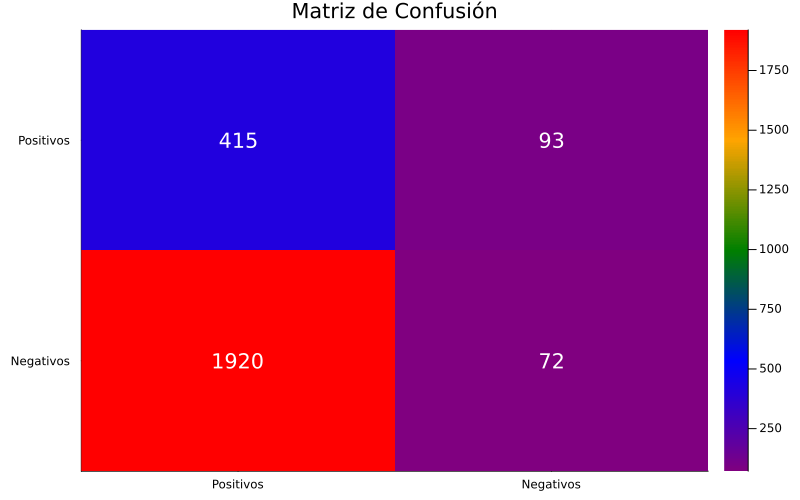

In [ ]:
# Extraer valores del objeto confusion_matrix
tp = matriz_confusion.tp  # Verdaderos Positivos
tn = matriz_confusion.tn  # Verdaderos Negativos
fp = matriz_confusion.fp  # Falsos Positivos
fn = matriz_confusion.fn  # Falsos Negativos

# Construir la matriz de confusión
m_c = [tn fp; fn tp]


for i in 1:size(m_c, 1)
    for j in 1:size(m_c, 2)
        annotate!(j, i, Plots.text(string(m_c[i, j]), :white, 14))
    end
end


# Coordenadas de los cuadros para las anotaciones
rows, cols = size(m_c)
x_coord = repeat(1:cols, inner=rows)
y_coord = repeat(1:rows, outer=cols)

# Texto con los valores de la matriz
texto = vec(string.(m_c))

# Graficar la matriz de confusión
Plots.heatmap(
    m_c,
    title="Matriz de Confusión",
    #xlabel="Predicción",
    #ylabel="Actual",
    c=:rainbow,
    xticks=(1:2, ["Positivos", "Negativos"]),
    yticks=(1:2, ["Negativos", "Positivos"]),
    colorbar=true,
    annotations=(x_coord, y_coord, texto, :white),
    size=(800, 500)
)

Las medidas obtenidas son:

In [ ]:
println("Exactitud = ", (tp + tn) / (tp + tn + fp + fn))
println("Sensibilidad = ", tp / (tp + fn))
println("Especificidad = ", tn / (tn + fp))

Exactitud = 0.8052
Sensibilidad = 0.1830708661417323
Especificidad = 0.963855421686747


# ROC

In [ ]:
function plot_roc_from_scratch(data::DataFrame, formula::FormulaTerm, target_variable::Symbol)
    # Fit GLM model
    model = glm(formula, data, Binomial(), LogitLink())

    # Predicted probabilities
    probs = predict(model, data)

    # Sort by predicted probabilities in descending order
    sorted_indices = sortperm(probs, rev=true)
    sorted_probs = probs[sorted_indices]
    sorted_labels = data[sorted_indices, target_variable]

    # Initialize variables
    tpr = Float64[]
    fpr = Float64[]
    tp = 0
    fp = 0
    p = sum(sorted_labels)  # Number of positives
    n = length(sorted_labels) - p  # Number of negatives

    # Calculate TPR and FPR at each threshold
    for i in 1:length(sorted_probs)
        if sorted_labels[i] == 1
            tp += 1
        else
            fp += 1
        end
        push!(tpr, tp / p)
        push!(fpr, fp / n)
    end

    # Calculate AUC using trapezoidal rule
    auc = sum((tpr[2:end] + tpr[1:end-1]) .* (fpr[1:end-1] - fpr[2:end])) / 2

    # Plot ROC curve
    Plots.plot(fpr, tpr,
         label="Curva ROC (AUC = $(abs(round(auc, digits=3))))",
         xlabel="FPR",
         ylabel="TPR")
end

plot_roc_from_scratch (generic function with 1 method)

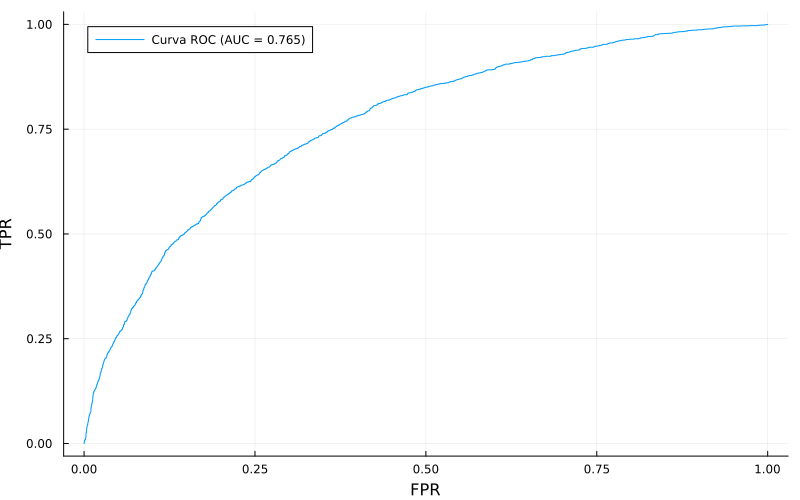

In [ ]:
Plots.plot(
plot_roc_from_scratch(datos, fm, :Exited),
size=(800, 500)
)

# Modelo de red neuronal usando Flux

Para esto, no se usara CUDA y el codigo se correra sin GPU, donde el codigo tienebuen despeño.

In [ ]:
# Convertir los datos a matrices para que Flux los procese correctamente
X_train = transpose(Matrix(select(datos_train, Not(:Exited))))  # Los datos de entrada de entrenamiento
y_train = transpose(Matrix(select(datos_train, :Exited)))  # Las etiquetas de entrenamiento (sin necesidad de convertir a Matrix)
X_test = transpose(Matrix(select(datos_test, Not(:Exited))))  # Los datos de entrada de prueba
y_test = transpose(Matrix(select(datos_test, :Exited))) # Las etiquetas de prueba (sin necesidad de convertir a Matrix)

println("Dimención de datos entrenamiento (X): ",size(X_train))
println("Dimención de datos entrenamiento (y): ", size(y_train))
println("Dimención de datos prueba (X): ", size(X_test))
println("Dimención de datos prueba (X): ", size(y_test))

Dimención de datos entrenamiento (X): (10, 7500)
Dimención de datos entrenamiento (y): (1, 7500)
Dimención de datos prueba (X): (10, 2500)
Dimención de datos prueba (X): (1, 2500)


In [ ]:
# Definir el modelo, un perceptrón multicapa con una capa oculta de tamaño 3:
modelo = Chain(
    Dense(size(X_train, 1) => 5, tanh),  # Activación dentro de la capa oculta
    BatchNorm(5),                        # Normalización por lotes
    Dense(5 => 1, sigmoid)                     # Capa de salida con activación sigmoide
)

# Inicializar el optimizador (Adam con tasa de aprendizaje de 0.01)
optimizador = Flux.setup(Flux.Adam(0.005), modelo)

# Entrenamiento: ciclo de entrenamiento con lotes de tamaño 64
cargador = Flux.DataLoader((X_train, y_train), batchsize=64, shuffle=true)

perdidas = []

@showprogress for epoca in 1:1000  # Ciclo de entrenamiento 1000 veces
    for (x, y) in cargador
        # Entrenamiento del modelo y cálculo de la pérdida
        perdida, gradientes = Flux.withgradient(modelo) do m
            y_hat = m(x)  # Predicción
            Flux.binarycrossentropy(y_hat, y)  # Función de pérdida binaria
        end
        # Actualizar los parámetros del modelo
        Flux.update!(optimizador, modelo, gradientes[1])
        # Registrar la pérdida
        push!(perdidas, perdida)
    end
end

# Evaluar el modelo con los datos de prueba
salida_final = modelo(X_test)               # Predicción con los datos de prueba
probabilidades_finales = salida_final       # Las probabilidades ya están normalizadas por sigmoide

# Calcular la precisión (accuracy)
predicciones = probabilidades_finales .> 0.5  # Clase predicha (umbral 0.5)
precisión = mean(predicciones .== y_test)    # Comparar con las etiquetas reales
println("Precisión en los datos de prueba (datos_test): ", precisión)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


Precisión en los datos de prueba (datos_test): 0.796


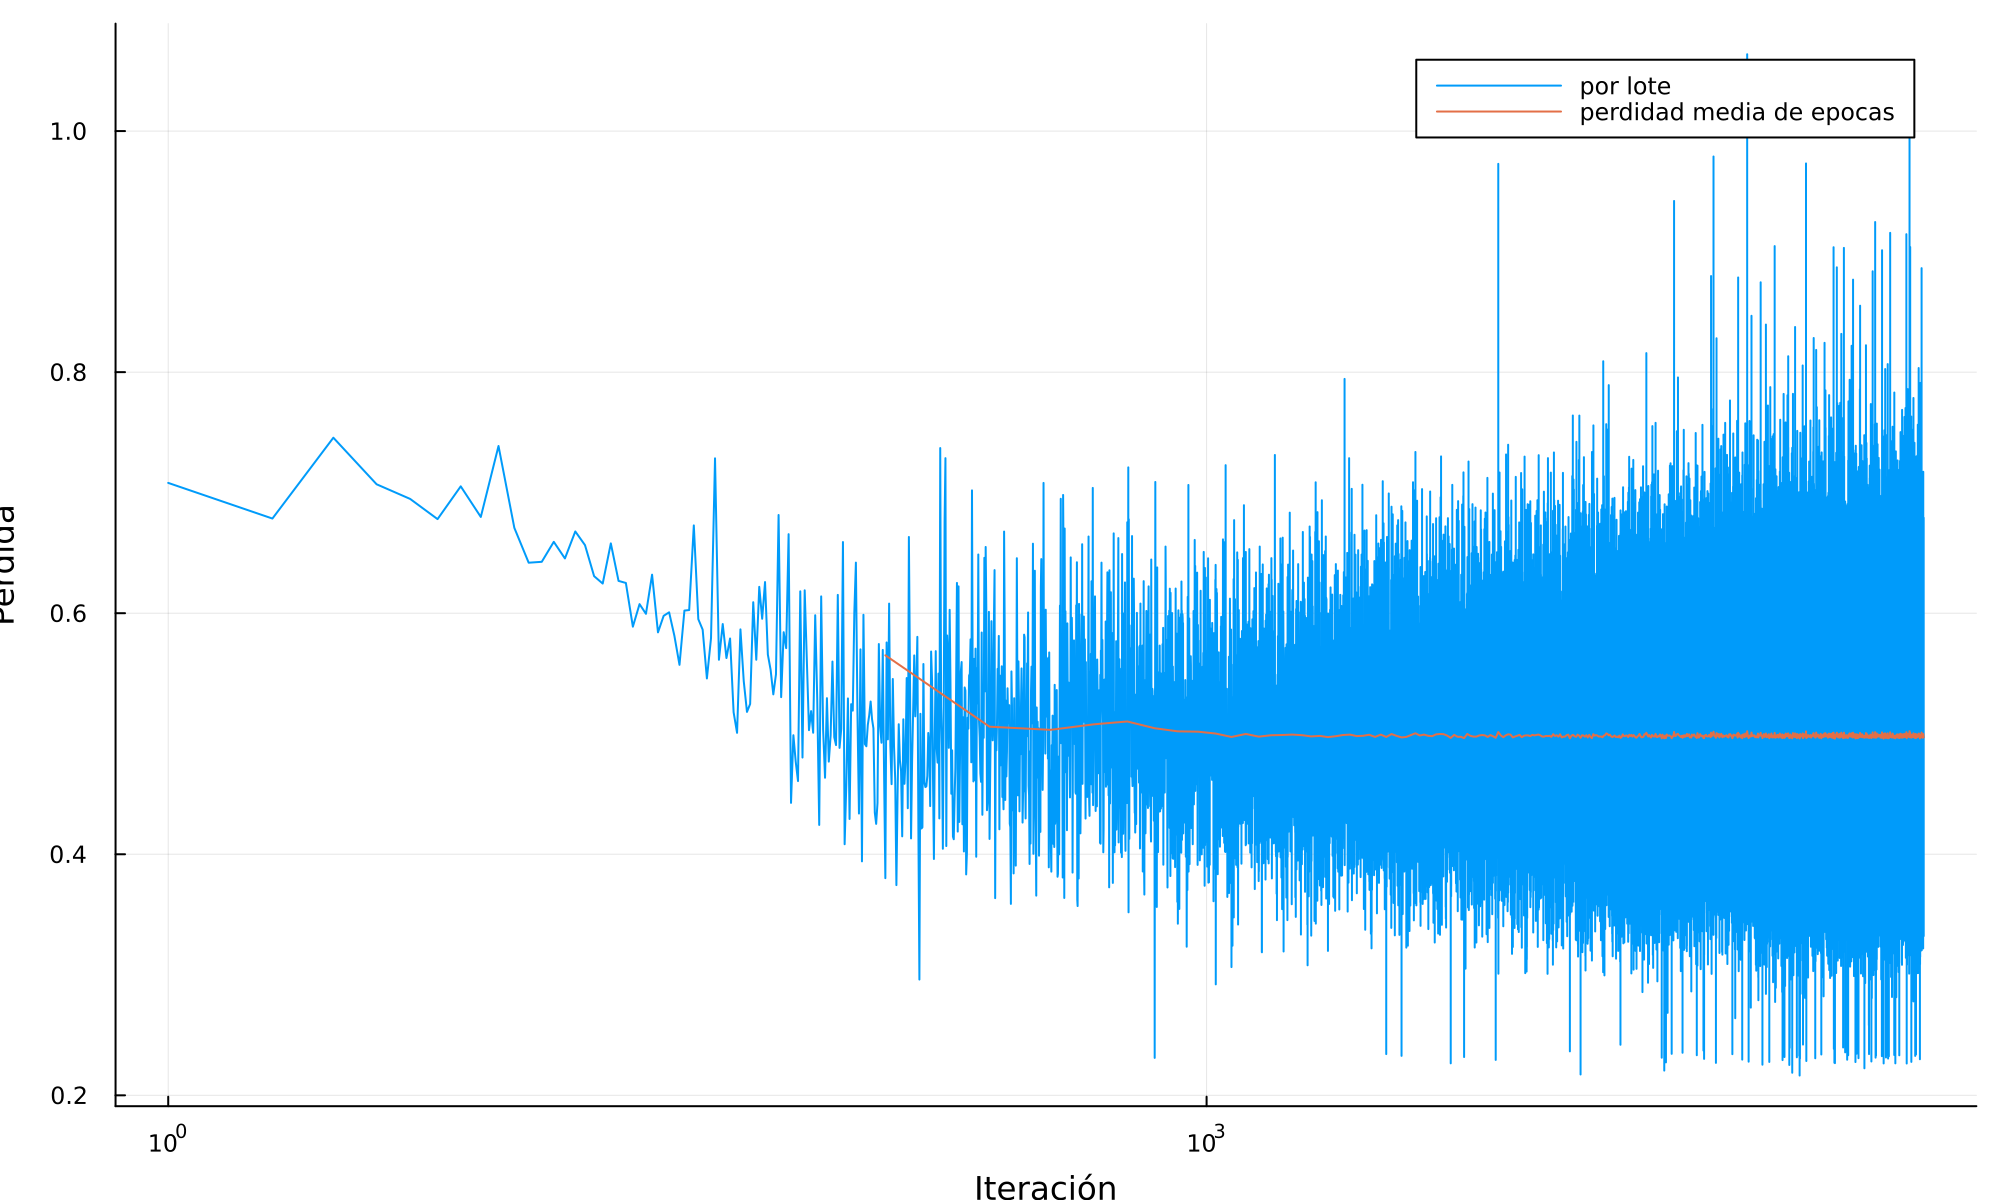

In [ ]:
Plots.plot(perdidas; xaxis=(:log10, "Iteración"),
    yaxis="Perdida", label="por lote")
n = length(cargador)
Plots.plot!(n:n:length(perdidas), mean.(Iterators.partition(perdidas, n)),
    label="perdidad media de epocas", dpi=200, size=(1000, 600))

Por l tanto, podemos ver que la precisión de la regresión logistica es mejor. Pero hay que considerar las pocas neuronas que se usaron en una sola capa. Además la diferencia no es significativa en erminos de los modelos. Cabe resaltar la rapidez del entrenamiento de la red en Julia, siendo una gran ventaja este modleo en este lenguaje.